# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Readme - Running our code is pretty straightforward. The comments will explicitely state what to do further down wherever human input is required. For running our code, you'll need sklearn, matplotlib, seaborn, pandas,numpy, random and re which are commonly used libraries which you will probably have installed. Lastly, the only data you'll need is what was initially provided to us all on brightspace. 


### Importing necessary libraries

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
from random import randint
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
# Magic command for high def plots in case of a Retina display
%config InlineBackend.figure_format = 'retina'

### Reading in the Data (The one provided to us in brightspace.)

In [2]:
data = "data_for_student_case.csv" #Provide the path to the data here.
df_OG = pd.read_csv(data)

### Preprocessing 

In [3]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    # Here we simply remove the refuse class from our dataframe.
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    
    #3-6 is made to be 3 for cvcresponsecode variable.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc = LabelEncoder()
    enc.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc.transform(df1.txvariantcode)

    enc = LabelEncoder()
    enc.fit(df1['currencycode'])
    df1['currencycode'] = enc.transform(df1.currencycode)

    enc = LabelEncoder()
    enc.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc.transform(df1.shopperinteraction)

    enc = LabelEncoder()
    enc.fit(df1['accountcode'])
    df1['accountcode'] = enc.transform(df1.accountcode)

    enc = LabelEncoder()
    enc.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc.transform(df1.cardverificationcodesupplied)
    
    enc = LabelEncoder()
    enc.fit(df1['mail_id'])
    df1['mail_id'] = enc.transform(df1.mail_id)

    
    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    #Converting creation and booking date to datestamps.
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])
    
    #Obtaining the day of week and hour of transactions using date timestamps. 
    df1['date'] = df1['creationdate'].dt.date 
    df1['day_of_week'] = df1['creationdate'].dt.dayofweek
    df1['hour'] = df1['creationdate'].dt.hour
    
    #converting creation date to unix_timestap.
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    #Standardizing amount to a single currency.
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    #df1 = df1.loc[~((df1['simple_journal'] == 0)&(df1['amount_eur']>320))]
    return df1
# Pre-processing the dataframe.
df1=preprocess(df_OG)

### Transaction Class distributions.

In [4]:
print("Number of total data points after removing 'refused' transactions = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['simple_journal'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['simple_journal'] == 0])))

Number of total data points after removing 'refused' transactions = 237036
Number of fradulent transactions = 345
Number of valid transactions = 236691


## 1. Visualization task 

#### I) Account Code and Number of Fraud

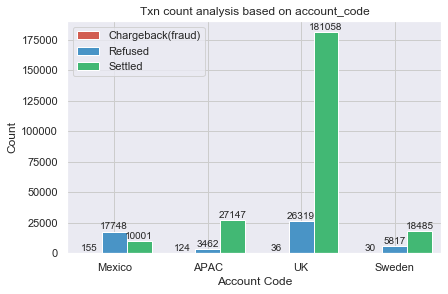

In [6]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="accountcode", hue="simple_journal", data=df_OG, palette=flatui)
ax.set_title('Txn count analysis based on account_code')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Account Code')
ax.set(xticklabels=["Mexico","APAC","UK","Sweden"])
ax.legend(["Chargeback(fraud)","Refused", "Settled"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height),
            ha="center",size=10)

**Description** - Based on this barchart, we see that there is an uneven distribution between fraudulent and non-fraudulent cases. Firstly, in general the fraud cases are in stark minority to the non-fraud cases. Secondly the uneven distribution (in terms of transactions) also plagues the data based on different accounts in our dataset, geographically. We observe that the majority of fraud cases originate from Mexico based accounts even though majority (number of) transactions have occured from UK based accounts. 

#### II) Amount in Euros Distribution for Fraud vs Normal

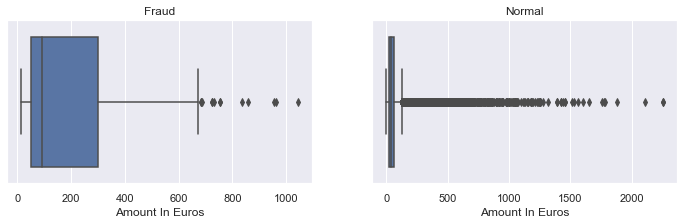

In [6]:
df_f = df1.loc[df1.simple_journal==1]
df_nf = df1.loc[df1.simple_journal==0]
nf_amt=df_nf.amount_eur.values
f_amt=df_f.amount_eur.values 
f, (ax1, ax2) = plt.subplots(1,2,figsize =(12, 3))
sns.boxplot(f_amt,ax=ax1)
ax1.set_title('Fraud')
sns.boxplot(nf_amt,ax=ax2)
ax2.set_title('Normal')
ax2.set_xlabel("Amount In Euros")
ax1.set_xlabel("Amount In Euros")
plt.show()

**Description** - From these boxplots, we observe that fraudulent transactions have a wider inter-quartile range than non-fraudulent cases with respect to amount in euros spent, per transaction (EUR/transaction). Additionally, the distribution of amount in euros for fraudulent transactions generally seems to be higher than non-fraudlent cases as indicated by the two medians. However, we need to keep in mind that there are many outliers for the 'non-fraudulent' transactions. 

#### III) Temporal relationship between Currency_code and number of fraudulent transactions

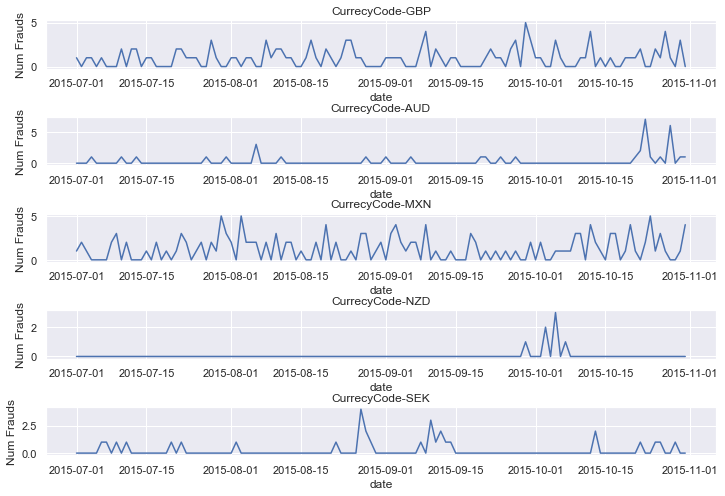

In [7]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['date','simple_journal']].groupby(['date']).sum()
df_AUD = df_AUD[['date','simple_journal']].groupby(['date']).sum()
df_MXN = df_MXN[['date','simple_journal']].groupby(['date']).sum()
df_NZD = df_NZD[['date','simple_journal']].groupby(['date']).sum()
df_SEK = df_SEK[['date','simple_journal']].groupby(['date']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(12, 8))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

**Description** - Based on the temporal lineplots above, we see that fraudulent transactions happen more frequently for the GBP and MXN currency codes. Secondly, we do not see any significant overlaps between dates, especially for the dates on which some currency codes show high number of fraud cases! This clearly suggests that date is not a common denominator when it comes to analysing fraudulent transactions.

#### IV) Difference in mean amount in euros with respect to cvcresponse code for fraud and non fraud cases.

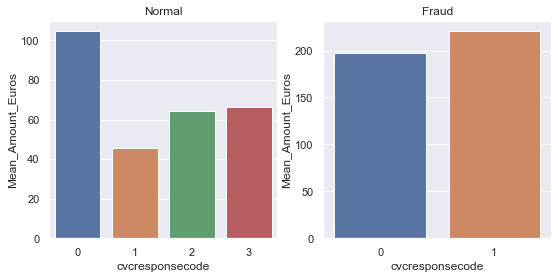

In [8]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[df1["simple_journal"]==0]
df5 = dff[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
df6 = df_nf[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")

plt.show()

**Description** - Based on the barcharts shown above we can see that for normal transactions, the mean amount in euros is higher for a cvcresponsecode of *0* which corresponds to a case where the presence/absence of the CVC/CVV2 code was *unknown* or not recorded. However, for fraud cases, the mean amount in euros is higher for a cvcresponsecode of *1* which corresponds to a case where the CVC/CVV2 code was entered correctly (i.e. match). We believe this is indicative of fact that fraudsters were good at disguising their transactions making them seem close to real ones (non-fraudulent txns). We also note that the mean amount in euros is actually much higher for fraudulent cases than for non-fraudulent transactions. This can be supported with respect to the boxplots we discussed previously.

#### V) Percentage fraud cases associated with cvcresponsecode for local vs international transactions

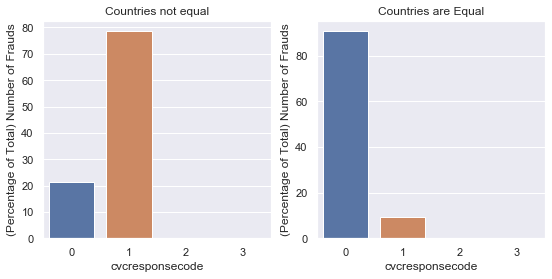

In [9]:
dff= df1.loc[df1["countries_equal"]==1]
df_nf=df1.loc[df1["countries_equal"]==0]
df5 = dff[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df5["simple_journal"].sum()
df5["simple_journal"]=(df5["simple_journal"]/total)*100
df6 = df_nf[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df6["simple_journal"].sum()
df6["simple_journal"]=(df6["simple_journal"]/total)*100
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['simple_journal'],ax=ax2)
ax2.set(ylabel = "(Percentage of Total) Number of Frauds")
ax2.set_title("Countries are Equal")
sns.barplot(x=df6.index,y=df6['simple_journal'],ax=ax1)
ax1.set(ylabel = "(Percentage of Total) Number of Frauds")
ax1.set_title("Countries not equal")
plt.show()

**Description** - Based on the barcharts shown above we can see that for international transactions (i.e. transactions with currencycode different than the accountissuercountrycode), the percentage of fraud cases with a cvcresponsecode of 1 is higher whereas for local transactions, the cvcresponsecode with a value of 0 is the majority. It can be concluded that the fraudulent transactions conducted in a currency other than the one associated with the  account (we're calling it an international *fraud* transaction), usually had the correct CVC/CVV2 code. This was not necessarily the case (as observed) with local *fraud* transactions!

#### VI) Issuercountrycode and mean amount in euros for fraud vs normal transactions.

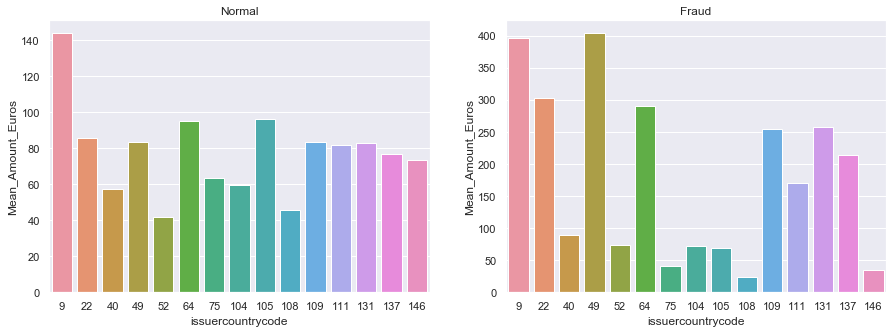

In [10]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[(df1["simple_journal"]==0) & (df1["issuercountrycode"].isin([9,22,40,49,52,64,75,104,105,108,109,111,131,137,146]))]
df5 = dff[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
df6 = df_nf[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 5))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

**Description**- Based on this barchart of *mean-amount vs issuercountrycode*, we observe that fraudulent transactions actually have a higher mean amount (expenditure) in most countries when compared to normal (non-fraudulent) transactions. We additionally see that the distribution of expenditure for different countries is not homogenous; with the highest amount in euros (mean) for fraudulent transcations occuring in issuer_country_codes 49 and 9 which is not necessrily same for normal (non-fraudulent) transactions.

#### VII) TxVariant and Mean Amount in Euros for normal and fraud cases

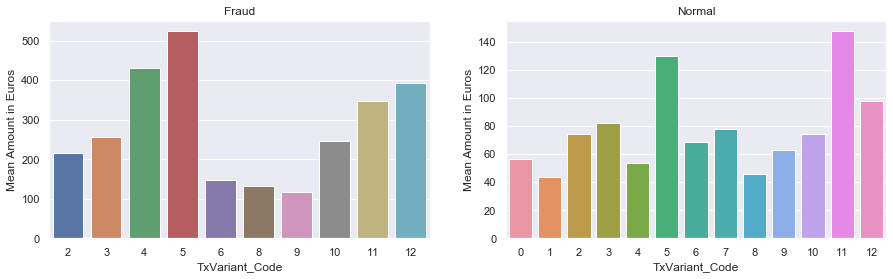

In [11]:
df2 = df1.loc[df1["simple_journal"]==1][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 4))
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean Amount in Euros")
ax1.set_xlabel('TxVariant_Code')
ax1.set_title("Fraud")
df2 = df1.loc[df1["simple_journal"]==0][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
sns.set(style="whitegrid")
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean Amount in Euros")
ax2.set_xlabel('TxVariant_Code')
ax2.set_title("Normal")
plt.show()

**Description** - The barchart plotting *Mean amount vs the TxnVariant_Code*, allows us to showcase a comparison between mean amount (in euros) for different txvariant_codes (codes are indicative of the brand/sub-brand of credit-card being used). Just like in previous visualisation, we see a common trend that mean amount in euros is usually higher in case of fraudulent transactions. We observe that the TxVariant_codes 11 and 5 have the highest mean amount (in euros) per fraudulent transaction. 

## 2. Imbalance task – Anwesh Marwade (5052068)

### SMOTE implementation with optional tomek link removal
Following is the implementation of Synthetic Minority Over-sampling Technique with optional Tomek link removal.

In [5]:
import random
import math

# for tomek links implementation
from sklearn.neighbors import NearestNeighbors

'''
Function to find the k nearest neighbours
'''
def k_neighbors(curr_row, data, k):
    dist_list = list()
    for idx in range(len(data)):
        dist = euclidean_distance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
    for i in range(k):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours
    
'''
Calculate the Euclidean distance between two vectors
'''
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)

'''
SMOTE function:
    T => Number of minority Samples available
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    returns a list of synthetic samples
'''
def smote(T,N,k,minority_samples):
    
# if N < 100, sample from random percent of minority instances
    if N < 100:
        T = (N/100) * T
        N = 100 # since we changed T now, make N = 100
        
# N controls the number of synthetic samples generated per data point
    N = (int)(N/100)
    synthetic_samples = list()
    
    for i in range(T):
        counter = N
# If k = 0, the nearest neighbour is the point itself.
        if(k):
            nn_list = k_neighbors(minority_samples[i], minority_samples, k)
        else:
            rand_knbr = i
        while counter:
            rand_nn = random.randint(1, len(nn_list) - 1)
            rand_knbr = nn_list[rand_nn]
            sample_row = []
            for attr in range(len(minority_samples[i])):
                diff = minority_samples[rand_knbr][attr] - minority_samples[i][attr]
                rand_gap = random.uniform(0, 1)
                sample_row.append(int(minority_samples[i][attr] + rand_gap*diff))
            synthetic_samples.append    
            synthetic_samples.append(sample_row)
            counter = counter - 1
    
    return synthetic_samples

'''
Wrapper for the SMOTE function:
default tomek_link = False (links are not removed)
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    tomek_links => True: remove tomek_links, False: do not remove
'''
def smote_wrapper(df1, N, k, tomek_links = False):
# Drop these columns from the parent df
    prep_df = df1.copy()
    
# Separate out the fraud and non-fraud instances
    not_fraud_df = prep_df.loc[prep_df["simple_journal"] == 0]
    fraud_df = prep_df.loc[prep_df['simple_journal'] == 1]
    minority_samples = np.array(fraud_df)
    cols = prep_df.columns
# Generate 'N%' new synthetic samples condsidering 'k' nearest neighbours
    synthetic_fraud_df = pd.DataFrame(smote(len(minority_samples), N, k, minority_samples),
                                      columns=cols)  
    
# intermediate_df -> synthetic + non-fraud samples
    intermediate_df = pd.concat([synthetic_fraud_df, not_fraud_df])

# fraud_df with synthetic samples
    fraud_syn_df = pd.concat([fraud_df, synthetic_fraud_df], sort=False)
    
# Tomek Links
    len_fraud = len(synthetic_fraud_df.values)
    if(tomek_links):
        remove_idx=[]
        intermediate_df_mat = intermediate_df.values
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(intermediate_df)
        distances, indices = nbrs.kneighbors(intermediate_df_mat[:len_fraud])
        for i in indices:
            if i[1] > len_fraud:
                remove_idx.append(i[0])
        needed = list(set(np.arange(len_fraud)) - set(remove_idx))
        needed_df = pd.DataFrame([synthetic_fraud_df.iloc[i] for i in needed])
        
        augmented_fraud_df = pd.concat([fraud_df, needed_df], sort=False)
        
        
        return pd.concat([augmented_fraud_df, not_fraud_df], sort=False)
        

    return pd.concat([fraud_syn_df, not_fraud_df], sort = False)

### Function to Undersample majority class
Majority class is undersampled to have a distribution -> num(majority_samples) = (p/100) * num(minority_samples), where p is the percent value provided.

In [6]:
from sklearn.utils import resample

def downsample_majority_class(df1, percent):
    df = df1.copy()
    
    not_fraud_df = df.loc[df["simple_journal"] == 0]
    fraud_df = df.loc[df['simple_journal'] == 1]
    if(percent):
        num_samples = int(len(fraud_df) * (100/percent))
    else:
        num_samples = len(fraud_df)
    not_fraud_downsampled = resample(not_fraud_df,
                                    replace = False, # sample without replacement
                                    n_samples = num_samples, # match minority n
                                    random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([not_fraud_downsampled, fraud_df])
    
    return downsampled

### Apply SMOTE and Undersampling to the data

In [7]:
from sklearn.preprocessing import StandardScaler
y = df1.drop(['txid', 'bookingdate', 'date', 'creationdate'], axis=1)['simple_journal']
X = df1.drop(['txid', 'bookingdate', 'date', 'creationdate'], axis=1)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=3)

# We will Smote the X_train data
# 500% or 5 times the minority samples with 2 nearest neighbours
# Tomek Links not removed if tomek_links is set to false
smoted_df = smote_wrapper(x_train, N = 500, k = 2, tomek_links = True)

# undersampling will have 'percent' amount of samples of the majority class.
# 50% implies -> count(minority samples) = 0.5 * count(majority samples)
smoted_df = downsample_majority_class(smoted_df, percent=20)
print(smoted_df['simple_journal'].value_counts())

# drop the labels from the training and testing data
x_train = x_train.drop(['simple_journal'], axis=1)
x_test = x_test.drop(['simple_journal'], axis=1)

unsmote_scaler = StandardScaler().fit(x_train)
X_train = unsmote_scaler.transform(x_train)
X_test = unsmote_scaler.transform(x_test)

0    5705
1    1141
Name: simple_journal, dtype: int64


**NOTE**
1. We first split the data into train and test (70/30)
2. Apply Smote and undersample the **training data** into a 'smoted_df', keeping testing data separate
3. We will then compare the performance of the Normal (Unsmoted Data) vs this smoted_df on this untouched **test data**
4. We scale the features of train and test data using **StandardScaler**, fitted on the training-data after making the train-test split.

We visualize the difference in the data distribution using a couple of scatter-plots as follows:

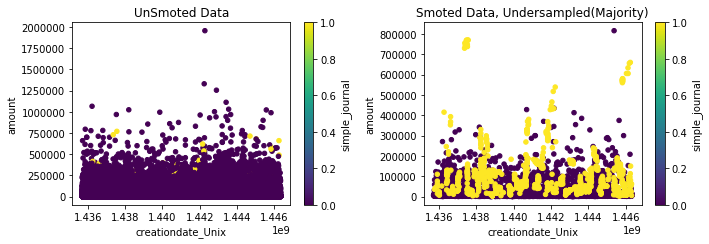

In [8]:
# Scatter Plots to visualize the SMOTE results
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
df1.reset_index().plot.scatter(x='creationdate_Unix', y='amount', c='simple_journal', colormap='viridis',
                               ax=ax, title='UnSmoted Data')
smoted_df.reset_index().plot.scatter(x='creationdate_Unix', y='amount', c='simple_journal', colormap='viridis', 
                                     ax=ax2, title='Smoted Data, Undersampled(Majority)')
fig.tight_layout()

### 2a. To SMOTE or not to SMOTE?
In order to begin this discussion, we train three classifiers to help understand what SMOTE'ing the data does to our 
classification performance. We discuss the results in a later section!

_Applying the following classifiers on Smoted Data & UnSmoted Data._

In [9]:
# Scaler on Smoted data
y_train_smoted = smoted_df['simple_journal']
smoted_df = smoted_df.drop(['simple_journal'], axis=1)
smote_scaler = StandardScaler().fit(smoted_df)
X_train_smoted = smote_scaler.transform(smoted_df)
# X_test_smoted is the same test-set which is just scaled differently, using the transform from X_train_smoted
X_test_smoted = smote_scaler.transform(x_test)
# For the annot alignment in sns heatmap
akws = {"ha": 'center',"va": 'center'}

#### 1. Naive Bayes Classifier

In [46]:
# Original unsmoted data
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("NB on UnSmoted data: Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], 
                                                                                         (y_test != y_pred).sum()))
print("Naive Bayes Accuracy (unsmoted): %.2f" %(metrics.accuracy_score(y_test, y_pred)*100))

y_pred_proba = gnb.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
y_test_nb_unsmoted = y_test

gnb_smote = GaussianNB()
y_pred_smote = gnb_smote.fit(X_train_smoted, y_train_smoted).predict(X_test_smoted)
print("NB on smoted data: Number of mislabeled points out of a total %d points : %d" 
      %(X_test.shape[0], (y_test != y_pred_smote).sum()))
print("Naive Bayes Accuracy (Smoted): %.2f" %(metrics.accuracy_score(y_test, y_pred_smote)*100))

y_pred_proba_smote = gnb_smote.predict_proba(X_test_smoted)[::,1]
fpr_smote, tpr_smote, thresholds_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)


NB on UnSmoted data: Number of mislabeled points out of a total 71111 points : 2975
Naive Bayes Accuracy (unsmoted): 95.82
NB on smoted data: Number of mislabeled points out of a total 71111 points : 12173
Naive Bayes Accuracy (Smoted): 82.88


The Test distribution is:
0    71007
1      104
Name: simple_journal, dtype: int64


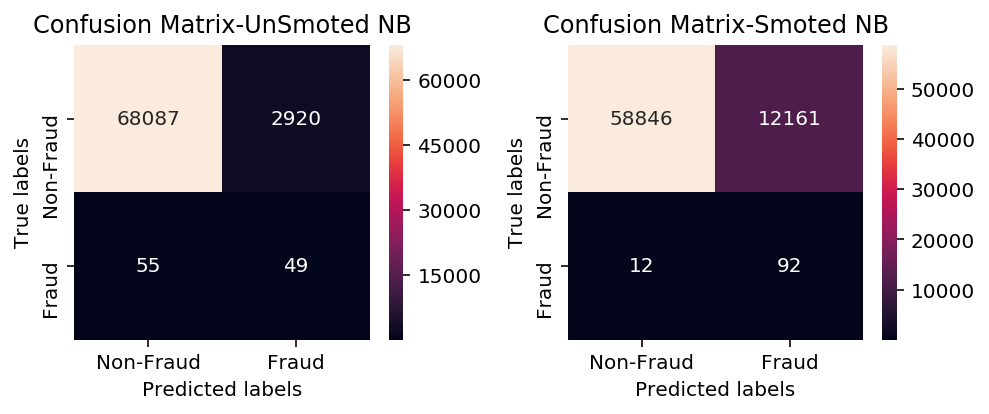

In [47]:
from sklearn.metrics import confusion_matrix

nb_unsmoted_cm = confusion_matrix(y_test_nb_unsmoted, y_pred)
nb_smoted_cm = confusion_matrix(y_test, y_pred_smote)

######################## UnSMOTED Confusion Matrix ###########################

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
# ax = fig_1.add_subplot()
sns.heatmap(nb_unsmoted_cm, annot=True, ax = ax, fmt="d", annot_kws=akws); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-UnSmoted NB')
ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])

# ######################## SMOTED Confusion Matrix ###########################

# fig_2 = plt.figure(2)  
# ax = fig_2.add_subplot()
sns.heatmap(nb_smoted_cm, annot=True, ax = ax2, fmt="d", annot_kws=akws); #annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix-Smoted NB')
ax2.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax2.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])
print('The Test distribution is:')
print(y_test.value_counts())
fig.tight_layout()


#### 2. Logistic Classifier

In [31]:
# Original unsmoted data
# Max iters allows to converge
logistic_clf = LogisticRegression(solver='lbfgs', random_state=0, max_iter=1000)
y_pred = logistic_clf.fit(X_train, y_train).predict(X_test)

print("LogisticClassifier on UnSmoted data: mislabeled points out of a total %d points : %d" 
      %(X_test.shape[0], (y_test != y_pred).sum()))
print("LogisticClassifier Accuracy (UnSmoted): %.2f "%(metrics.accuracy_score(y_test, y_pred)*100))

y_pred_proba = logistic_clf.predict_proba(X_test)[::,1]
fpr_lc, tpr_lc, thresholds_lc = metrics.roc_curve(y_test, y_pred_proba)
auc_lc = metrics.roc_auc_score(y_test, y_pred_proba)

# SMOTED
logistic_clf_smote = LogisticRegression(solver='lbfgs', random_state=0, max_iter=1000)
y_pred_smote = logistic_clf_smote.fit(X_train_smoted, y_train_smoted).predict(X_test_smoted)

print("LogisticClassifier on smoted data: mislabeled points out of a total %d points : %d" 
      %(X_test.shape[0], (y_test != y_pred_smote).sum()))
print("LogisticClassifier Accuracy: %.2f "%(metrics.accuracy_score(y_test, y_pred_smote)*100))

y_pred_proba_smote = logistic_clf_smote.predict_proba(X_test_smoted)[::,1]
fpr_lc_smote, tpr_lc_smote, thresholds_lc_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_lc_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)


LogisticClassifier on UnSmoted data: mislabeled points out of a total 71111 points : 109
LogisticClassifier Accuracy (UnSmoted): 99.85 
LogisticClassifier on smoted data: mislabeled points out of a total 71111 points : 2992
LogisticClassifier Accuracy: 95.79 


The Test distribution is:
0    71007
1      104
Name: simple_journal, dtype: int64


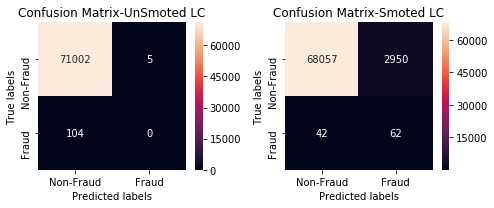

In [32]:
from sklearn.metrics import confusion_matrix

lc_unsmoted_cm = confusion_matrix(y_test, y_pred)
lc_smoted_cm = confusion_matrix(y_test, y_pred_smote)

######################## UnSMOTED Confusion Matrix ###########################

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
# ax = fig_1.add_subplot()
sns.heatmap(lc_unsmoted_cm, annot=True, ax = ax, fmt="d", annot_kws=akws); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-UnSmoted LC')
ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])

# ######################## SMOTED Confusion Matrix ###########################

# fig_2 = plt.figure(2)  
# ax = fig_2.add_subplot()
sns.heatmap(lc_smoted_cm, annot=True, ax = ax2, fmt="d", annot_kws=akws); #annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix-Smoted LC')
ax2.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax2.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])
print('The Test distribution is:')
print(y_test.value_counts())
fig.tight_layout()


#### 3. Random Forest Classifier

In [33]:
# Original unsmoted data
# WARNING: RF might take a bit of time to process, reduce n_estimators to a lesser value
# n_estimators = 100 -> 100 trees generated for RF classification

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
y_pred = rf_clf.fit(X_train, y_train).predict(X_test)

print("RF on UnSmoted data: mislabeled points out of a total %d points : %d" %(X_test.shape[0]
                                                                               , (y_test != y_pred).sum()))
print("RF Accuracy (UnSmoted): %.2f "%(metrics.accuracy_score(y_test, y_pred)*100))

y_pred_proba = rf_clf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_proba)
auc_rf = metrics.roc_auc_score(y_test, y_pred_proba)

# SMOTED
rf_clf_smote = RandomForestClassifier(n_estimators=100, random_state=0)
y_pred_smote = rf_clf_smote.fit(X_train_smoted, y_train_smoted).predict(X_test_smoted)

print("RF on smoted data: mislabeled points out of a total %d points : %d" %(X_test.shape[0]
                                                                             , (y_test != y_pred_smote).sum()))
print("RF Accuracy: %.2f "%(metrics.accuracy_score(y_test, y_pred_smote)*100))

y_pred_proba_smote = rf_clf_smote.predict_proba(X_test_smoted)[::,1]
fpr_rf_smote, tpr_rf_smote, thresholds_rf_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_rf_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)


RF on UnSmoted data: mislabeled points out of a total 71111 points : 98
RF Accuracy (UnSmoted): 99.86 
RF on smoted data: mislabeled points out of a total 71111 points : 1177
RF Accuracy: 98.34 


The Test distribution is:
0    71007
1      104
Name: simple_journal, dtype: int64


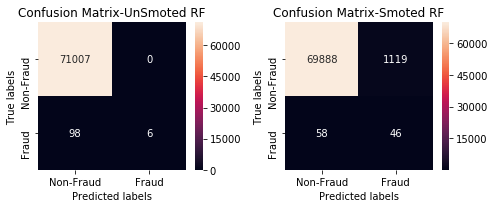

In [34]:
from sklearn.metrics import confusion_matrix

rf_unsmoted_cm = confusion_matrix(y_test, y_pred)
rf_smoted_cm = confusion_matrix(y_test, y_pred_smote)

######################## UnSMOTED Confusion Matrix ###########################

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
sns.heatmap(rf_unsmoted_cm, annot=True, ax = ax, fmt="d", annot_kws=akws); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-UnSmoted RF')
ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])

# ######################## SMOTED Confusion Matrix ###########################

sns.heatmap(rf_smoted_cm, annot=True, ax = ax2, fmt="d", annot_kws=akws); #annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix-Smoted RF')
ax2.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax2.yaxis.set_ticklabels(['Non-Fraud', 'Fraud'])
print('The Test distribution is:')
print(y_test.value_counts())
fig.tight_layout()


#### ROC Curves

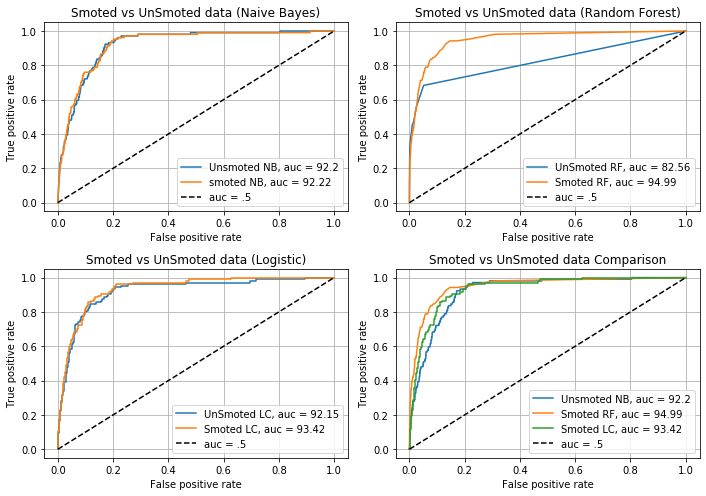

In [35]:
# AUC curve

fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))


ax.plot(fpr, tpr, label="Unsmoted NB, auc = " +str(round(auc*100,2)))
ax.plot(fpr_smote, tpr_smote, label = "smoted NB, auc = "+str(round(auc_smote*100,2)))
ax.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title("Smoted vs UnSmoted data (Naive Bayes)")
ax.legend(loc=4)
ax.grid()

# AUC curve for RF

ax1.plot(fpr_rf, tpr_rf, label = "UnSmoted RF, auc = "+str(round(auc_rf*100,2)))
ax1.plot(fpr_rf_smote, tpr_rf_smote, label="Smoted RF, auc = " +str(round(auc_rf_smote*100,2)))
ax1.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title("Smoted vs UnSmoted data (Random Forest)")
ax1.legend(loc=4)
ax1.grid()

# AUC curve for LC

ax2.plot(fpr_lc, tpr_lc, label = "UnSmoted LC, auc = "+str(round(auc_lc*100,2)))
ax2.plot(fpr_lc_smote, tpr_lc_smote, label="Smoted LC, auc = " +str(round(auc_lc_smote*100,2)))
ax2.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title("Smoted vs UnSmoted data (Logistic)")
ax2.legend(loc=4)
ax2.grid()


# AUC curve for ALL

ax3.plot(fpr, tpr, label="Unsmoted NB, auc = " +str(round(auc * 100,2)))
ax3.plot(fpr_rf_smote, tpr_rf_smote, label="Smoted RF, auc = " +str(round(auc_rf_smote * 100,2)))
ax3.plot(fpr_lc_smote, tpr_lc_smote, label="Smoted LC, auc = " +str(round(auc_lc_smote * 100,2)))
ax3.plot([0,1], [0,1], 'k--', label = "auc = .5")
ax3.set_xlabel('False positive rate')
ax3.set_ylabel('True positive rate')
ax3.set_title("Smoted vs UnSmoted data Comparison")
ax3.legend(loc=4)
ax3.grid()


fig.tight_layout()
plt.show()

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

**'Best Performance'** is not a straightforward target to chase in this scenario due to the inherent data imbalance. The accuracy alone, for example, provides a poor evaluation of the model especially in case of **unsmoted data**, as is apparent from the confusion matrices (for unsmoted data) eventhough the accuracy is generally good i.e. in the early _**90 percents**_ on average. It is hence understood that high accuracy scores for the given data do not translate into good classification-per-class; all three classifiers, show poor classification for the fraudulent cases which are in minority and end up getting classsified in the majority (non-fradulent) class while being able to uphold the high accuracy values. _For example:_ The Random Forest Classifier outputs a **_99.86%_** accuracy (face-value) but on looking under the hood at the classification performance per-class (using confusion-matrices and ROC curves) it is only able to classify **(6/104)** fraudulent samples from the test set, showing a measly **_5%_** accuracy in identifying fradulent cases! The performance for the non-fraud (majority-class) case is expectedly higher.

It is hence imperative to analyse the **ROC-curves** which highlight the distinguishing power of a classifier by varying the discrimination threshold for this binary classification scenario. In order to understand the performance of the classifier for this task, is important to look at the trade-off between generating False-Positives (Non-Fraudulent txns classified as Fraudulent txns). To realise, compare the confusion matrices for these classifiers... one can see that while Naive-Bayes has the highest accuracy for fradulent cases **(91/104)**, it comes at the cost of **_11,900_ false-positives**! i.e. **~10x** greater than the observed false-positives for the Logistic or the Random-Forest classifier! Trying to reduce the no. of false positives, brings us back to the situation where our classifier is unable to identify the fradulent txns (the results are aggravated in case of UnSmoted data). 

**ROC(AUC) Curves**: For a classification system, the _Receiver Operating Characteristic (ROC)_ curve and its corresponding _Area Under the Curve(AUC)_ allow us to understand the diagnostic ability of the said binary classifier (this case) by varying the classification threshold. The importance of ROC(AUC) is highlighted by the performance of the Random Forest classifier, where it posits an accuracy of _**99.86%**_ which -on the face of it- paints the perfect picture! By analysing the ROC curve, however, we understand that this bump in accuracy is indeed realised by classifying almost all of the majority class correctly (~zero false classifications) while having **<10%** classification accuracy on the minority class (only catching **6/104** Fraud cases). This suggests an extremely poor performance for the given _Fraud Detection Task_ (even in comparison with the other two classifiers).


Hence, we are of the opinion that we need to strike a balance in being able to distinguish fraudulent txns (which is the minority class) while keeping the False-Positive Rate (fpr: x-axis for the ROC) manageable. It might eventually depend on the cost of filtering through each transaction. For example, In case this cost is very resource intensive, having a low FPR might be preferable over being able to catch all the fraudulent cases.

Based on this discussion and our obtained results, we suggest using the **Logistic classifier on SMOTE'd data**. With a minority-class accuracy of **_~58%_** and **_2,885_** False-Positives, it seems to strike a balance between the high FPR seen in the Naive Bayes implementation and the relatively less classsification performance for fraudulent-txns observed in the Random-Forest Classifier. 

**Addendum:** It might be preferable to use Random forests as well (in certain cases where a high FPR cannot be tolerated) which gives **_~50%_** accuracy on the minority class while having quite low number for False-Positives in working with SMOTE'd data! 

_The numbers are subject to change_

### 2c. Is using SMOTE a good idea? Why (not)?

On Comparing the results of the classifier performance on both UnSMOTE'd and SMOTE'd data, we see that _synthetically oversampling the minority-class samples_ and later _undersampling the majority-class_ (basic process of SMOTE'ing), drastically improves the classification accuracy for the minorty-class albeit (again) with an added overhead of more number of False Positives... We also worked with the optional **tomek-link** removal where we see that removing the minority samples which occur very close to majority data-point(s) (by using nearest-neighbour), does help in improving the minority-class classification by enhancing 'separability'. We keep tomek-link removal optional as we encountered some instances where it reduced the number of True Negatives (the fraud-cases). Although the enhancement/reduction is minimal(more of a refinement) we advise caution in this aspect due to the fact that with the hope of enhancing separability, it could in-turn reduce the classification power (lesser samples). In our opinion this happens to the the small number of fraud-samples with which we are working. To encapsulate the performance-comparison (**accuracy on the minority-class**) for classification with and without applying SMOTE, we provide the following table:

|  Classifier | SMOTE'd | UnSMOTE'd | SMOTE'd (Tomek-Links) |
|:-----------:|:-------:|:---------:|:---------------------:|
| Naive Bayes |  86.53% |   47.11%  |       **87.5%**       |
|   Logistic  |  57.69% |     0     |       **60.5%**       |
| Rndm Forest |   5.7%  |   45.19%  |       **46.15%**      |

Training by applying **SMOTE** on the data shows considerable improvement in terms of classification performance on the minority (fraud) class. Note that the performance is further improved by removing **tomek links** i.e. dropping the data samples with its nearest-neighbor as a majority class sample. This probably enhances the distinguising ability of the classifier. We hence use SMOTE with tomek link removal in our classification task.

Additionally, as seen in the results, by using **SMOTE**, we end up providing the classifier enough data (from the minority-class) to be able to model the minority-class. It is clear that without using SMOTE, the classifiers are not able to sufficiently model the fradulent-class which is reflected in the poor accuracy scores (for the minority-class in the UnSMOTE'd case). However, by SMOTE'ing (as discussed in the previous section), the classifiers output an increasing number of False-Positives (Non-fraud cases classified as Fraud), which in our opinion is a trade-off that needs to be considered mindfully w.r.t the preformance requirements!

## 3. Privacy task – Aditya Kunar (5074274)

**NOTE**
1. I create four datasets in the following ways-
    a) Only ordinal columns such as amount_eur, day of the week, hour and creationdate_Unix are rank swapped.
    b) All columns are rank swapped.
    c) No rank-swapping is done.
    d) I also vary the percentage constraint to 20 percent when performing rank-swapping to all columns .
    e) Additionally, I create another seperate scenario in which I also clean the above four datasets based on the visualisation seen about amount_eur having many outliers.
2. I perform a stratified split to the the four different datasets to create a train and test set with 2/3 of the samples in train and 1/3 in test.
3. I scale the features of train and test data using **MinMaxScaler**, fitted on the training-data after making the train-test split.
4. I subsample the data-points of the non-fraud cases randomly such that I have 20 percent of fraud cases in my full training set and I do this for all three dataset types as discussed in the first point.
5. I then fit my 3 different classifiers and print ROC curves.
6. I then conclude with an analysis of my results.


In [36]:
#What the data looks like without swapping
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,accountcode,mail_id,ip_id,card_id,countries_equal,date,day_of_week,hour,creationdate_Unix,amount_eur
0,1,2015-11-09 14:26:51,104,2,1998,64800.0,2,104,1,1,...,1,187702,7386,73358,1,2015-07-01,2,23,1435791791,30.446979
1,2,2015-11-09 14:27:38,104,2,2364,44900.0,2,104,1,1,...,1,834,194109,44739,1,2015-07-02,3,4,1435812655,21.096749
2,3,2015-11-23 16:34:16,104,2,1965,149900.0,2,104,1,1,...,1,119287,189655,122802,1,2015-07-02,3,14,1435847428,70.432131
3,4,2015-11-23 16:34:51,104,2,2374,109900.0,2,104,1,1,...,1,173561,8254,70712,1,2015-07-03,4,7,1435910017,51.637700
4,5,2015-11-09 14:26:08,104,6,1301,89900.0,2,104,1,1,...,1,70647,196247,208481,1,2015-07-08,2,18,1436380535,42.240484


In [37]:
#Cleaning the dataset as amount_eur had alot of outliers for the non_fraud cases as can be seen in the visualisation.
df_clean=df1.loc[~((df1['simple_journal'] == 0)&(df1['amount_eur']>320))]

In [38]:
#These columns are not relevant to the classifier and can therefore be ignored.
df_notswapped = df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
df_notswapped_clean = df_clean.drop(columns=['txid','creationdate','bookingdate','amount','date'])

In [39]:
# Rank swapping function. Explaination about the implementation is through the comments within the function.
'''
RankSwap function:
    perc => What percentage of rows can two ranked indices be allowed to swap. 
            It basically constrains the swapping of an element to a certain range.
    column => Which column do you want to independently apply rank-swapping to.
    df => Which dataframe do you want to do the operation of rank-swapping on.
    returns a dataframe with the appropriate column rank-swapped.
'''
def rank_swap(perc,column,df):
    #Percentage of total rows for which we can safely switch two ranked items in a column.
    p = perc
    #The column for which we wish to do the rank swapping.
    c = column
    #Sort the dataframe based on the column in ascending order
    sortbycol = df.sort_values(c)
    #Extract the index of the dataframe.
    sortedbycolindex=sortbycol.index.to_list()
    #Calculate the interval within which swaps of ranked values are allowed.
    interval = int(len(df.index)*(p/100))
    #This set checks if values of certain indices have already been swapped and skips those values.
    value_list=set()
    for i in range(len(sortedbycolindex)):
        if i in value_list:
            continue
        #Just sampling a random value and doing it until the value agrees with the interval.    
        value = randint(0,len(sortedbycolindex)-1)
        while(abs(i-value)>interval):
            value = randint(0,len(sortedbycolindex)-1)
        #Adding swapped value indexes to the value_list set.
        value_list.add(value)
        #Doing the actual swap. 
        sortedbycolindex[i], sortedbycolindex[value] = sortedbycolindex[value], sortedbycolindex[i]
    
    #Reordering a new dataframe based on index.
    newdf=df.reindex(sortedbycolindex)  
    #Getting the values in the order we need.
    v=newdf[c]
    #Assigning the values of that order in the original dataframe
    df[c]=v.values
    #Returning the dataframe and exiting the function.
    return df     

In [40]:
#My code for random subsampling. If k is 10, you keep 10 percent fraud cases, 90 percent non-fraud cases. 
#X and Y 
'''
subsample function:
    This function randomly subsamples from the nonfraud data points.
    k => Controls the percentage of non-fraud to fraud cases. 
         If k is 10, you will have 10 percent fraud cases and 90 percent non-fraud cases.
         If k is 5, you will have 20 percent fraud cases and 80 percent non-fraud cases.
    x => x is the training data.
    y => y is the labels.  
    returns a subsampled training set and labels.
'''
def subsample(k,x,y):
    s=int(y.sum())
    posindex=[]
    for i in enumerate(y):
        if i[1]==1:
            posindex.append(i[0])
    fullindex=list(range(0,len(y)))
    sampleindex= list(set(fullindex)-set(posindex))
    randomlist = list(set(random.sample(range(0, len(sampleindex)),int(s*(k-1)))))
    randomlist = list(np.array(sampleindex)[randomlist])
    randomlist.extend(posindex)
    random.shuffle(randomlist)
    X_train=(x[randomlist])
    y_train=np.array(y)
    y_train=y[randomlist].ravel()
    return X_train,y_train

In [41]:
#Only rankswapping those columns with ordinal values.
df_swapped=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
df_swapped = rank_swap(10,"amount_eur",df_swapped)
df_swapped = rank_swap(10,"creationdate_Unix",df_swapped)
df_swapped = rank_swap(10,"day_of_week",df_swapped)
df_swapped = rank_swap(10,"hour",df_swapped)

In [42]:
#Only rankswapping those columns with ordinal values for the cleaned dataset.
df_swapped_clean=df_clean.drop(columns=['txid','creationdate','bookingdate','amount','date'])
df_swapped_clean = rank_swap(10,"amount_eur",df_swapped_clean)
df_swapped_clean = rank_swap(10,"creationdate_Unix",df_swapped_clean)
df_swapped_clean = rank_swap(10,"day_of_week",df_swapped_clean)
df_swapped_clean = rank_swap(10,"hour",df_swapped_clean)

In [43]:
#swapping every column.
df_allswapped=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
for i in df_notswapped.columns:
    df_allswapped=rank_swap(10,i,df_allswapped)

In [44]:
#swapping every column.
df_allswapped_20=df1.drop(columns=['txid','creationdate','bookingdate','amount','date'])
for i in df_notswapped.columns:
    df_allswapped_20=rank_swap(20,i,df_allswapped_20)

In [16]:
#swapping every column for the cleaned dataset.
df_allswapped_clean=df_clean.drop(columns=['txid','creationdate','bookingdate','amount','date'])
for i in df_notswapped.columns:
    df_allswapped_clean=rank_swap(10,i,df_allswapped_clean)

In [17]:
#swapping every column for the cleaned dataset.
df_allswapped_clean_20=df_clean.drop(columns=['txid','creationdate','bookingdate','amount','date'])
for i in df_notswapped.columns:
    df_allswapped_clean_20=rank_swap(20,i,df_allswapped_clean_20)

In [18]:
#Looking at non-swapped data.
df_notswapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,104,2,1998,2,104,1,1,1,0,1,187702,7386,73358,1,2,23,1435791791,30.446979
1,104,2,2364,2,104,1,1,1,0,1,834,194109,44739,1,3,4,1435812655,21.096749
2,104,2,1965,2,104,1,1,1,0,1,119287,189655,122802,1,3,14,1435847428,70.432131
3,104,2,2374,2,104,1,1,1,0,1,173561,8254,70712,1,4,7,1435910017,51.637700
4,104,6,1301,2,104,1,1,1,0,1,70647,196247,208481,1,2,18,1436380535,42.240484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,784,4,131,1,0,1,1,2,23852,16764,196325,1,5,23,1446333718,45.228021
290378,131,3,2508,4,131,1,0,1,1,2,106775,67997,27390,1,5,23,1446334284,183.356841
290379,131,8,784,4,131,1,0,1,1,2,152970,87084,36581,1,5,23,1446334900,49.365303
290380,131,3,2508,4,131,1,0,1,1,2,206916,66888,36060,1,5,23,1446335407,82.463564


In [19]:
#Looking at rank-swapped data with only ordinal columns.
df_swapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,104,2,1998,2,104,1,1,1,0,1,187702,7386,73358,1,0,1,1435943152,14.612532
1,104,2,2364,2,104,1,1,1,0,1,834,194109,44739,1,0,2,1436069652,11.061530
2,104,2,1965,2,104,1,1,1,0,1,119287,189655,122802,1,0,2,1436018785,9.427440
3,104,2,2374,2,104,1,1,1,0,1,173561,8254,70712,1,0,0,1436589111,10.653007
4,104,6,1301,2,104,1,1,1,0,1,70647,196247,208481,1,0,2,1435739653,9.396015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,784,4,131,1,0,1,1,2,23852,16764,196325,1,6,23,1445188027,62.849601
290378,131,3,2508,4,131,1,0,1,1,2,106775,67997,27390,1,5,23,1444512373,126.939351
290379,131,8,784,4,131,1,0,1,1,2,152970,87084,36581,1,6,22,1445600967,208.990353
290380,131,3,2508,4,131,1,0,1,1,2,206916,66888,36060,1,6,22,1444071916,114.511973


In [20]:
#Looking at swapped data with all columns being rank-swapped
df_allswapped

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,9,2,691,0,9,1,0,0,0,0,14655,6371,9324,1,0,0,1435778679,15.712400
1,9,2,698,0,9,1,0,0,0,0,16531,6331,13907,0,0,1,1435731261,11.909999
2,9,2,40,0,9,1,0,0,0,0,13301,19254,19609,1,0,0,1435923147,15.680975
3,9,2,698,0,9,1,0,0,0,0,19036,13498,2454,1,0,1,1436546691,5.797236
4,9,2,97,0,9,0,0,0,0,0,3683,1482,17620,1,0,0,1436003429,5.591343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,131,8,2569,2,131,1,1,1,1,3,207516,186126,201271,1,6,21,1446213394,128.118913
290378,131,10,2508,4,104,1,0,1,1,3,172861,176943,194318,1,6,22,1446135422,230.155239
290379,111,10,1805,4,155,1,0,1,1,3,200681,173097,205524,1,6,22,1444593938,302.275156
290380,131,10,2465,4,146,1,0,1,1,3,208718,203904,206581,1,6,23,1444329660,141.748942


In [21]:
# Creating the data and the labels for training.
X1 = df_swapped.drop(columns="simple_journal")
y1 = df_swapped["simple_journal"]
X2 = df_allswapped.drop(columns="simple_journal")
y2 = df_allswapped["simple_journal"]
X3 = df_notswapped.drop(columns="simple_journal")
y3 = df_notswapped["simple_journal"]
X4 = df_allswapped_20.drop(columns="simple_journal")
y4 = df_allswapped_20["simple_journal"]
# Creating the data and the labels for training for the cleaned dataset as well.
X1_clean = df_swapped_clean.drop(columns="simple_journal")
y1_clean = df_swapped_clean["simple_journal"]
X2_clean = df_allswapped_clean.drop(columns="simple_journal")
y2_clean = df_allswapped_clean["simple_journal"]
X3_clean = df_notswapped_clean.drop(columns="simple_journal")
y3_clean = df_notswapped_clean["simple_journal"]
X4_clean = df_allswapped_clean_20.drop(columns="simple_journal")
y4_clean = df_allswapped_clean_20["simple_journal"]

In [22]:
#Creating the split of train and test-: 2/3 train, 1/3 test. 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,stratify=y1,test_size=0.33)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,stratify=y2,test_size=0.33)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,stratify=y3,test_size=0.33)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,stratify=y4,test_size=0.33)
#Creating the split of train and test-: 2/3 train, 1/3 test for the cleaned dataset as well. 
X1_train_clean, X1_test_clean, y1_train_clean, y1_test_clean = train_test_split(X1_clean,y1_clean,stratify=y1_clean,test_size=0.33)
X2_train_clean, X2_test_clean, y2_train_clean, y2_test_clean = train_test_split(X2_clean,y2_clean,stratify=y2_clean,test_size=0.33)
X3_train_clean, X3_test_clean, y3_train_clean, y3_test_clean = train_test_split(X3_clean,y3_clean,stratify=y3_clean,test_size=0.33)
X4_train_clean, X4_test_clean, y4_train_clean, y4_test_clean = train_test_split(X4_clean,y4_clean,stratify=y4_clean,test_size=0.33)

In [23]:
#Scaling the data before we feed it into the classifier. 
scaler = MinMaxScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)
scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)
scaler.fit(X3_train)
X3_train = scaler.transform(X3_train)
X3_test = scaler.transform(X3_test)
scaler.fit(X4_train)
X4_train = scaler.transform(X4_train)
X4_test = scaler.transform(X4_test)
#Scaling the data before we feed it into the classifier. 
scaler = MinMaxScaler()
scaler.fit(X1_train_clean)
X1_train_clean = scaler.transform(X1_train_clean)
X1_test_clean = scaler.transform(X1_test_clean)
scaler.fit(X2_train_clean)
X2_train_clean = scaler.transform(X2_train_clean)
X2_test_clean = scaler.transform(X2_test_clean)
scaler.fit(X3_train_clean)
X3_train_clean = scaler.transform(X3_train_clean)
X3_test_clean = scaler.transform(X3_test_clean)
scaler.fit(X4_train_clean)
X4_train_clean = scaler.transform(X4_train_clean)
X4_test_clean = scaler.transform(X4_test_clean)

In [24]:
#Number of samples and the number of fraud cases in train and test before subsampling. 
(X3_train.shape,y3_train.sum()),(X3_test.shape,y3_test.sum())

(((158814, 17), 231), ((78222, 17), 114))

In [25]:
#Number of samples and the number of fraud cases in train and test before subsampling for cleaned dataset. 
(X3_train_clean.shape,y3_train_clean.sum()),(X3_test_clean.shape,y3_test_clean.sum())

(((157787, 17), 231), ((77716, 17), 114))

In [26]:
# Sub-sampling the majority class in the training set. 
X1_train,y1_train= subsample(5,X1_train,np.array(y1_train))
X2_train,y2_train= subsample(5,X2_train,np.array(y2_train))
X3_train,y3_train= subsample(5,X3_train,np.array(y3_train))
X4_train,y4_train= subsample(5,X4_train,np.array(y4_train))
# Sub-sampling the majority class in the training set for cleaned dataset. 
X1_train_clean,y1_train_clean= subsample(5,X1_train_clean,np.array(y1_train_clean))
X2_train_clean,y2_train_clean= subsample(5,X2_train_clean,np.array(y2_train_clean))
X3_train_clean,y3_train_clean= subsample(5,X3_train_clean,np.array(y3_train_clean))
X4_train_clean,y4_train_clean= subsample(5,X4_train_clean,np.array(y4_train_clean))

In [27]:
#Number of samples and the number of fraud cases in train and test after subsampling. 
(X4_train.shape,y4_train.sum()),(X4_test.shape,y4_test.sum())

(((1155, 17), 231), ((78222, 17), 114))

In [28]:
#Number of samples and the number of fraud cases in train and test after subsampling for the cleaned dataset. 
(X4_train_clean.shape,y4_train_clean.sum()),(X4_test_clean.shape,y4_test_clean.sum())

(((1155, 17), 231), ((77716, 17), 114))

### 3a. ROC curves for the respective classifiers

### Naive Baye's Classifier.

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 12321
accuracy:  0.8424867684283194
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 14458
accuracy:  0.8151670885428651
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 12502
accuracy:  0.8401728414001176
Number of mislabeled points out of a total 78222 points for all-swapped dataset but with 20 percent: 21961
accuracy:  0.719247781953926
(True neg, False pos, False neg, True Pos) for the four datasets respectively:
(65805, 12303, 18, 96)
(63650, 14458, 0, 114)
(65627, 12481, 21, 93)
(56149, 21959, 2, 112)
Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 12365
accuracy:  0.8408950537855783
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 14280
accuracy:  0.8162540532194142
Number of mislabeled points out of a total 77716 points for non-swapped data

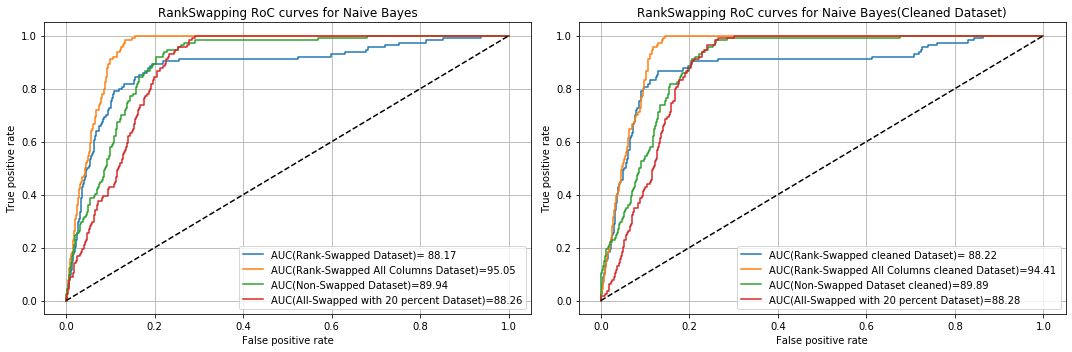

In [29]:
#Defining the classifier
cnb = ComplementNB()

#Fitting the data and making predictions.
y1_pred = cnb.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = cnb.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)

#Fitting the data and making predictions.
y2_pred = cnb.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = cnb.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)

#Fitting the data and making predictions.
y3_pred = cnb.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = cnb.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)

#Fitting the data and making predictions.
y4_pred = cnb.fit(X4_train, y4_train).predict(X4_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for all-swapped dataset but with 20 percent: %d" %(X4_test.shape[0], (y4_test != y4_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y4_test, y4_pred))

#Plotting ROC Curves.
y4_pred_proba = cnb.predict_proba(X4_test)[::,1]
fpr4, tpr4, thresholds4 = metrics.roc_curve(y4_test, y4_pred_proba)
auc4 = metrics.roc_auc_score(y4_test, y4_pred_proba)

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(y4_test,y4_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the four datasets respectively:")
print("%s" %((tn1, fp1, fn1, tp1),))
print("%s" %((tn2, fp2, fn2, tp2),))
print("%s" %((tn3, fp3, fn3, tp3),))
print("%s" %((tn4, fp4, fn4, tp4),))
#Fitting the data and making predictions.
y1_pred_clean = cnb.fit(X1_train_clean, y1_train_clean).predict(X1_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test_clean.shape[0], (y1_test_clean != y1_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test_clean, y1_pred_clean))

#Plotting ROC Curves.
y1_pred_proba_clean = cnb.predict_proba(X1_test_clean)[::,1]
fpr1_clean, tpr1_clean, thresholds1_clean = metrics.roc_curve(y1_test_clean, y1_pred_proba_clean)
auc1_clean = metrics.roc_auc_score(y1_test_clean, y1_pred_proba_clean)

#Fitting the data and making predictions.
y2_pred_clean = cnb.fit(X2_train_clean, y2_train_clean).predict(X2_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test_clean.shape[0], (y2_test_clean != y2_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test_clean, y2_pred_clean))

#Plotting ROC Curves.
y2_pred_proba_clean = cnb.predict_proba(X2_test_clean)[::,1]
fpr2_clean, tpr2_clean, thresholds2_clean = metrics.roc_curve(y2_test_clean, y2_pred_proba_clean)
auc2_clean = metrics.roc_auc_score(y2_test_clean, y2_pred_proba_clean)

#Fitting the data and making predictions.
y3_pred_clean = cnb.fit(X3_train_clean, y3_train_clean).predict(X3_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test_clean.shape[0], (y3_test_clean != y3_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test_clean, y3_pred_clean))

#Plotting ROC Curves.
y3_pred_proba_clean = cnb.predict_proba(X3_test_clean)[::,1]
fpr3_clean, tpr3_clean, thresholds3_clean = metrics.roc_curve(y3_test_clean, y3_pred_proba_clean)
auc3_clean = metrics.roc_auc_score(y3_test_clean, y3_pred_proba_clean)


#Fitting the data and making predictions.
y4_pred_clean = cnb.fit(X4_train_clean, y4_train_clean).predict(X4_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for all-swapped cleaned dataset with 20 percent: %d" %(X4_test_clean.shape[0], (y4_test_clean != y4_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y4_test_clean, y4_pred_clean))

#Plotting ROC Curves.
y4_pred_proba_clean = cnb.predict_proba(X4_test_clean)[::,1]
fpr4_clean, tpr4_clean, thresholds4_clean = metrics.roc_curve(y4_test_clean, y4_pred_proba_clean)
auc4_clean = metrics.roc_auc_score(y4_test_clean, y4_pred_proba_clean)

#Printing the confusion matrix details. 
tn1_clean, fp1_clean, fn1_clean, tp1_clean = confusion_matrix(y1_test_clean,y1_pred_clean).ravel()
tn2_clean, fp2_clean, fn2_clean, tp2_clean = confusion_matrix(y2_test_clean,y2_pred_clean).ravel()
tn3_clean, fp3_clean, fn3_clean, tp3_clean = confusion_matrix(y3_test_clean,y3_pred_clean).ravel()
tn4_clean, fp4_clean, fn4_clean, tp4_clean = confusion_matrix(y4_test_clean,y4_pred_clean).ravel()
print("(True neg, False pos, False neg, True Pos) for the four cleaned datasets respectively:")
print("%s" %((tn1_clean, fp1_clean, fn1_clean, tp1_clean),))
print("%s" %((tn2_clean, fp2_clean, fn2_clean, tp2_clean),))
print("%s" %((tn3_clean, fp3_clean, fn3_clean, tp3_clean),))
print("%s" %((tn4_clean, fp4_clean, fn4_clean, tp4_clean),))

# AUC curve

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))
ax1.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))
ax1.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))
ax1.plot(fpr4, tpr4, label="AUC(All-Swapped with 20 percent Dataset)=" +str(round(auc4*100,2)))
ax1.plot([0,1], [0,1], 'k--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title("RankSwapping RoC curves for Naive Bayes")
ax1.legend(loc=4)
ax1.grid()
ax2.plot(fpr1_clean, tpr1_clean, label="AUC(Rank-Swapped cleaned Dataset)= " +str(round(auc1_clean*100,2)))
ax2.plot(fpr2_clean, tpr2_clean, label="AUC(Rank-Swapped All Columns cleaned Dataset)=" +str(round(auc2_clean*100,2)))
ax2.plot(fpr3_clean, tpr3_clean, label="AUC(Non-Swapped Dataset cleaned)=" +str(round(auc3_clean*100,2)))
ax2.plot(fpr4_clean, tpr4_clean, label="AUC(All-Swapped with 20 percent Dataset)=" +str(round(auc4_clean*100,2)))
ax2.plot([0,1], [0,1], 'k--')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title("RankSwapping RoC curves for Naive Bayes(Cleaned Dataset)")
ax2.legend(loc=4)
ax2.grid()
fig.tight_layout()
plt.show()

### Logistic Regression

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 6973
accuracy:  0.9108562808417069
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 7318
accuracy:  0.9064457569481732
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 6817
accuracy:  0.9128506046892179
Number of mislabeled points out of a total 78222 points for all-swapped dataset but with 20 percent: 6985
accuracy:  0.9107028713149753
(True neg, False pos, False neg, True Pos) for the four datasets respectively:
(71167, 6941, 32, 82)
(70802, 7306, 12, 102)
(71336, 6772, 45, 69)
(71192, 6916, 69, 45)
Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 6640
accuracy:  0.9145607082196716
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 7283
accuracy:  0.9062869936692572
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 582

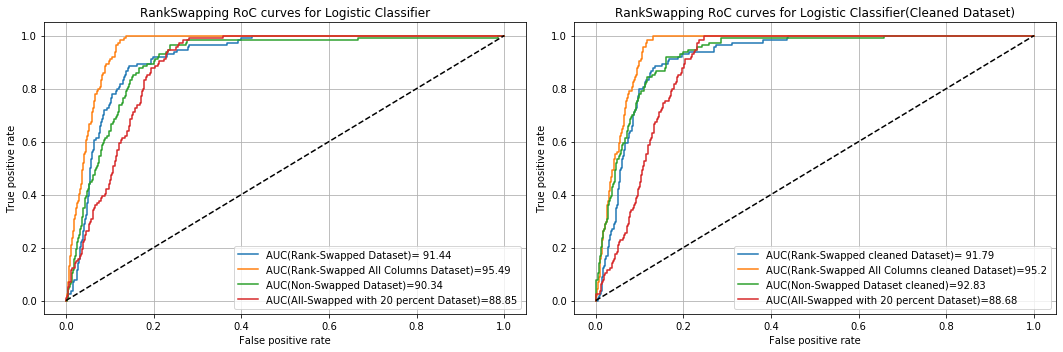

In [30]:
#Defining the classifier
clf =LogisticRegression(solver='lbfgs', max_iter=1000)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)

#Fitting the data and making predictions.
y4_pred = clf.fit(X4_train, y4_train).predict(X4_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for all-swapped dataset but with 20 percent: %d" %(X4_test.shape[0], (y4_test != y4_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y4_test, y4_pred))

#Plotting ROC Curves.
y4_pred_proba = clf.predict_proba(X4_test)[::,1]
fpr4, tpr4, thresholds4 = metrics.roc_curve(y4_test, y4_pred_proba)
auc4 = metrics.roc_auc_score(y4_test, y4_pred_proba)

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(y4_test,y4_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the four datasets respectively:")
print("%s" %((tn1, fp1, fn1, tp1),))
print("%s" %((tn2, fp2, fn2, tp2),))
print("%s" %((tn3, fp3, fn3, tp3),))
print("%s" %((tn4, fp4, fn4, tp4),))
#Fitting the data and making predictions.
y1_pred_clean = clf.fit(X1_train_clean, y1_train_clean).predict(X1_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test_clean.shape[0], (y1_test_clean != y1_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test_clean, y1_pred_clean))

#Plotting ROC Curves.
y1_pred_proba_clean = clf.predict_proba(X1_test_clean)[::,1]
fpr1_clean, tpr1_clean, thresholds1_clean = metrics.roc_curve(y1_test_clean, y1_pred_proba_clean)
auc1_clean = metrics.roc_auc_score(y1_test_clean, y1_pred_proba_clean)

#Fitting the data and making predictions.
y2_pred_clean = clf.fit(X2_train_clean, y2_train_clean).predict(X2_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test_clean.shape[0], (y2_test_clean != y2_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test_clean, y2_pred_clean))

#Plotting ROC Curves.
y2_pred_proba_clean = clf.predict_proba(X2_test_clean)[::,1]
fpr2_clean, tpr2_clean, thresholds2_clean = metrics.roc_curve(y2_test_clean, y2_pred_proba_clean)
auc2_clean = metrics.roc_auc_score(y2_test_clean, y2_pred_proba_clean)

#Fitting the data and making predictions.
y3_pred_clean = clf.fit(X3_train_clean, y3_train_clean).predict(X3_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test_clean.shape[0], (y3_test_clean != y3_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test_clean, y3_pred_clean))

#Plotting ROC Curves.
y3_pred_proba_clean = clf.predict_proba(X3_test_clean)[::,1]
fpr3_clean, tpr3_clean, thresholds3_clean = metrics.roc_curve(y3_test_clean, y3_pred_proba_clean)
auc3_clean = metrics.roc_auc_score(y3_test_clean, y3_pred_proba_clean)


#Fitting the data and making predictions.
y4_pred_clean = clf.fit(X4_train_clean, y4_train_clean).predict(X4_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for all-swapped cleaned dataset with 20 percent: %d" %(X4_test_clean.shape[0], (y4_test_clean != y4_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y4_test_clean, y4_pred_clean))

#Plotting ROC Curves.
y4_pred_proba_clean = clf.predict_proba(X4_test_clean)[::,1]
fpr4_clean, tpr4_clean, thresholds4_clean = metrics.roc_curve(y4_test_clean, y4_pred_proba_clean)
auc4_clean = metrics.roc_auc_score(y4_test_clean, y4_pred_proba_clean)

#Printing the confusion matrix details. 
tn1_clean, fp1_clean, fn1_clean, tp1_clean = confusion_matrix(y1_test_clean,y1_pred_clean).ravel()
tn2_clean, fp2_clean, fn2_clean, tp2_clean = confusion_matrix(y2_test_clean,y2_pred_clean).ravel()
tn3_clean, fp3_clean, fn3_clean, tp3_clean = confusion_matrix(y3_test_clean,y3_pred_clean).ravel()
tn4_clean, fp4_clean, fn4_clean, tp4_clean = confusion_matrix(y4_test_clean,y4_pred_clean).ravel()
print("(True neg, False pos, False neg, True Pos) for the four cleaned datasets respectively:")
print("%s" %((tn1_clean, fp1_clean, fn1_clean, tp1_clean),))
print("%s" %((tn2_clean, fp2_clean, fn2_clean, tp2_clean),))
print("%s" %((tn3_clean, fp3_clean, fn3_clean, tp3_clean),))
print("%s" %((tn4_clean, fp4_clean, fn4_clean, tp4_clean),))

# AUC curve

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))
ax1.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))
ax1.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))
ax1.plot(fpr4, tpr4, label="AUC(All-Swapped with 20 percent Dataset)=" +str(round(auc4*100,2)))
ax1.plot([0,1], [0,1], 'k--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title("RankSwapping RoC curves for Logistic Classifier")
ax1.legend(loc=4)
ax1.grid()
ax2.plot(fpr1_clean, tpr1_clean, label="AUC(Rank-Swapped cleaned Dataset)= " +str(round(auc1_clean*100,2)))
ax2.plot(fpr2_clean, tpr2_clean, label="AUC(Rank-Swapped All Columns cleaned Dataset)=" +str(round(auc2_clean*100,2)))
ax2.plot(fpr3_clean, tpr3_clean, label="AUC(Non-Swapped Dataset cleaned)=" +str(round(auc3_clean*100,2)))
ax2.plot(fpr4_clean, tpr4_clean, label="AUC(All-Swapped with 20 percent Dataset)=" +str(round(auc4_clean*100,2)))
ax2.plot([0,1], [0,1], 'k--')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title("RankSwapping RoC curves for Logistic Classifier(Cleaned Dataset)")
ax2.legend(loc=4)
ax2.grid()
fig.tight_layout()
plt.show()

### Gradient Boosting Classifier. 

Number of mislabeled points out of a total 78222 points for rank-swapped dataset : 4776
accuracy:  0.9389430083608192
Number of mislabeled points out of a total 78222 points for rank-swapped all columns dataset : 4511
accuracy:  0.9423308020761423
Number of mislabeled points out of a total 78222 points for non-swapped dataset: 3459
accuracy:  0.9557797039196134
Number of mislabeled points out of a total 78222 points for all-swapped dataset but with 20 percent: 1609
accuracy:  0.9794303392907366
(True neg, False pos, False neg, True Pos) for the four datasets respectively:
(73366, 4742, 34, 80)
(73650, 4458, 53, 61)
(74694, 3414, 45, 69)
(76604, 1504, 105, 9)
Number of mislabeled points out of a total 77716 points for rank-swapped dataset : 4970
accuracy:  0.936049204796953
Number of mislabeled points out of a total 77716 points for rank-swapped all columns dataset : 4957
accuracy:  0.9362164805188121
Number of mislabeled points out of a total 77716 points for non-swapped dataset: 3210


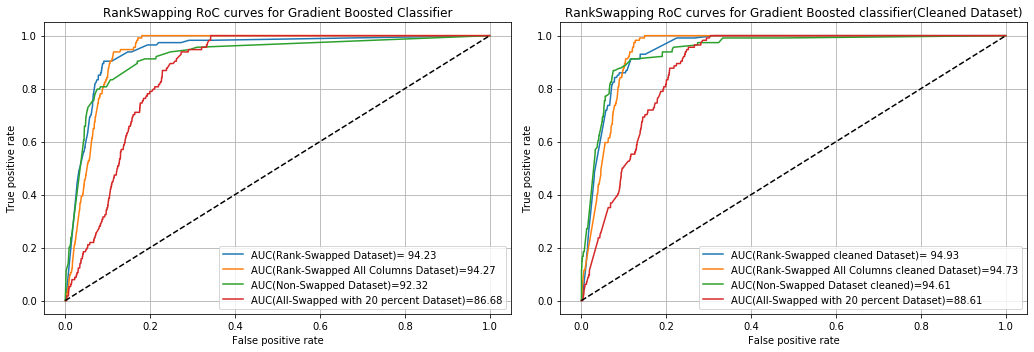

In [31]:
#Defining the classifier
clf = GradientBoostingClassifier(n_estimators=10)

#Fitting the data and making predictions.
y1_pred = clf.fit(X1_train, y1_train).predict(X1_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test.shape[0], (y1_test != y1_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test, y1_pred))

#Plotting ROC Curves.
y1_pred_proba = clf.predict_proba(X1_test)[::,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y1_test, y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)

#Fitting the data and making predictions.
y2_pred = clf.fit(X2_train, y2_train).predict(X2_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test.shape[0], (y2_test != y2_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test, y2_pred))

#Plotting ROC Curves.
y2_pred_proba = clf.predict_proba(X2_test)[::,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2_test, y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)

#Fitting the data and making predictions.
y3_pred = clf.fit(X3_train, y3_train).predict(X3_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test.shape[0], (y3_test != y3_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test, y3_pred))

#Plotting ROC Curves.
y3_pred_proba = clf.predict_proba(X3_test)[::,1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_test, y3_pred_proba)
auc3 = metrics.roc_auc_score(y3_test, y3_pred_proba)

#Fitting the data and making predictions.
y4_pred = clf.fit(X4_train, y4_train).predict(X4_test)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for all-swapped dataset but with 20 percent: %d" %(X4_test.shape[0], (y4_test != y4_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y4_test, y4_pred))

#Plotting ROC Curves.
y4_pred_proba = clf.predict_proba(X4_test)[::,1]
fpr4, tpr4, thresholds4 = metrics.roc_curve(y4_test, y4_pred_proba)
auc4 = metrics.roc_auc_score(y4_test, y4_pred_proba)

#Printing the confusion matrix details. 
tn1, fp1, fn1, tp1 = confusion_matrix(y1_test,y1_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y2_test,y2_pred).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y3_test,y3_pred).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(y4_test,y4_pred).ravel()
print("(True neg, False pos, False neg, True Pos) for the four datasets respectively:")
print("%s" %((tn1, fp1, fn1, tp1),))
print("%s" %((tn2, fp2, fn2, tp2),))
print("%s" %((tn3, fp3, fn3, tp3),))
print("%s" %((tn4, fp4, fn4, tp4),))
#Fitting the data and making predictions.
y1_pred_clean = clf.fit(X1_train_clean, y1_train_clean).predict(X1_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped dataset : %d" %(X1_test_clean.shape[0], (y1_test_clean != y1_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y1_test_clean, y1_pred_clean))

#Plotting ROC Curves.
y1_pred_proba_clean = clf.predict_proba(X1_test_clean)[::,1]
fpr1_clean, tpr1_clean, thresholds1_clean = metrics.roc_curve(y1_test_clean, y1_pred_proba_clean)
auc1_clean = metrics.roc_auc_score(y1_test_clean, y1_pred_proba_clean)

#Fitting the data and making predictions.
y2_pred_clean = clf.fit(X2_train_clean, y2_train_clean).predict(X2_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for rank-swapped all columns dataset : %d" %(X2_test_clean.shape[0], (y2_test_clean != y2_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y2_test_clean, y2_pred_clean))

#Plotting ROC Curves.
y2_pred_proba_clean = clf.predict_proba(X2_test_clean)[::,1]
fpr2_clean, tpr2_clean, thresholds2_clean = metrics.roc_curve(y2_test_clean, y2_pred_proba_clean)
auc2_clean = metrics.roc_auc_score(y2_test_clean, y2_pred_proba_clean)

#Fitting the data and making predictions.
y3_pred_clean = clf.fit(X3_train_clean, y3_train_clean).predict(X3_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for non-swapped dataset: %d" %(X3_test_clean.shape[0], (y3_test_clean != y3_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y3_test_clean, y3_pred_clean))

#Plotting ROC Curves.
y3_pred_proba_clean = clf.predict_proba(X3_test_clean)[::,1]
fpr3_clean, tpr3_clean, thresholds3_clean = metrics.roc_curve(y3_test_clean, y3_pred_proba_clean)
auc3_clean = metrics.roc_auc_score(y3_test_clean, y3_pred_proba_clean)


#Fitting the data and making predictions.
y4_pred_clean = clf.fit(X4_train_clean, y4_train_clean).predict(X4_test_clean)
#Printing accuracy.
print("Number of mislabeled points out of a total %d points for all-swapped cleaned dataset with 20 percent: %d" %(X4_test_clean.shape[0], (y4_test_clean != y4_pred_clean).sum()))
print("accuracy: ", metrics.accuracy_score(y4_test_clean, y4_pred_clean))

#Plotting ROC Curves.
y4_pred_proba_clean = clf.predict_proba(X4_test_clean)[::,1]
fpr4_clean, tpr4_clean, thresholds4_clean = metrics.roc_curve(y4_test_clean, y4_pred_proba_clean)
auc4_clean = metrics.roc_auc_score(y4_test_clean, y4_pred_proba_clean)

#Printing the confusion matrix details. 
tn1_clean, fp1_clean, fn1_clean, tp1_clean = confusion_matrix(y1_test_clean,y1_pred_clean).ravel()
tn2_clean, fp2_clean, fn2_clean, tp2_clean = confusion_matrix(y2_test_clean,y2_pred_clean).ravel()
tn3_clean, fp3_clean, fn3_clean, tp3_clean = confusion_matrix(y3_test_clean,y3_pred_clean).ravel()
tn4_clean, fp4_clean, fn4_clean, tp4_clean = confusion_matrix(y4_test_clean,y4_pred_clean).ravel()
print("(True neg, False pos, False neg, True Pos) for the four cleaned datasets respectively:")
print("%s" %((tn1_clean, fp1_clean, fn1_clean, tp1_clean),))
print("%s" %((tn2_clean, fp2_clean, fn2_clean, tp2_clean),))
print("%s" %((tn3_clean, fp3_clean, fn3_clean, tp3_clean),))
print("%s" %((tn4_clean, fp4_clean, fn4_clean, tp4_clean),))

# AUC curve

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(fpr1, tpr1, label="AUC(Rank-Swapped Dataset)= " +str(round(auc1*100,2)))
ax1.plot(fpr2, tpr2, label="AUC(Rank-Swapped All Columns Dataset)=" +str(round(auc2*100,2)))
ax1.plot(fpr3, tpr3, label="AUC(Non-Swapped Dataset)=" +str(round(auc3*100,2)))
ax1.plot(fpr4, tpr4, label="AUC(All-Swapped with 20 percent Dataset)=" +str(round(auc4*100,2)))
ax1.plot([0,1], [0,1], 'k--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title("RankSwapping RoC curves for Gradient Boosted Classifier")
ax1.legend(loc=4)
ax1.grid()
ax2.plot(fpr1_clean, tpr1_clean, label="AUC(Rank-Swapped cleaned Dataset)= " +str(round(auc1_clean*100,2)))
ax2.plot(fpr2_clean, tpr2_clean, label="AUC(Rank-Swapped All Columns cleaned Dataset)=" +str(round(auc2_clean*100,2)))
ax2.plot(fpr3_clean, tpr3_clean, label="AUC(Non-Swapped Dataset cleaned)=" +str(round(auc3_clean*100,2)))
ax2.plot(fpr4_clean, tpr4_clean, label="AUC(All-Swapped with 20 percent Dataset)=" +str(round(auc4_clean*100,2)))
ax2.plot([0,1], [0,1], 'k--')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title("RankSwapping RoC curves for Gradient Boosted classifier(Cleaned Dataset)")
ax2.legend(loc=4)
ax2.grid()
fig.tight_layout()
plt.show()

### 3b. Performance Analysis and Explaination for Differences within the Classifiers.

#### Naive Baye's Classifier-

Here I've used the complement naive baye's classifier which as mentioned in the sklearn documentation treats every variable as having a multinomial distribution which is in agreement with the kind of variables we have in our dataset as they are mostly categorical in nature. Additionally, this classifier is also specifically designed to deal with class imbalances as well. I would like to also mention that this model correctly classified almost all positive cases of fraud(113/114) in the test set for the (all-columns) rank-swapped dataset and similarly classified all 114 cases of fraud in the corresponding cleaned test set. However this comes at the cost of too many false positives(approx 13k to 14k) as well which is expected as this classifier has a high bias in general due to it's strong("naive") probabilistic assumptions about features being independent. 

Furthermore, for this classifier, we see that the area under the ROC curve which is a threshold independent method of understanding the performance of a classifier(higher is better) is highest for the datasets where all the columns are rank-swapped(10 percent constraint) for both the normal and cleaned test datasets. These results were quite surprising initially but I believe that this result can be explained by the fact that re-ordering all columns instead of just the few ordinal columns makes the entire dataset a bit more homogenous and at the same time can be seen as a form of regularisation in terms of noise injection into the input data thereby perhaps making it more difficult for the model to overfit on the test data as well. But at the same time, rank-swapping with a 20 percent constraint injects too much noise and leads to worse performance so we must be careful with that hyperparameter and tune it well. In addition, we also see that the non-rank-swapped datasets have a slightly higher AUC than the rank-swapped datasets where only ordinal columns have been swapped and this difference is much more consistent over multiple runs for the cleaned dataset as compared to the normal dataset.   

In terms of accuracy, we actually see that non-rank-swapped data with just the ordinal columns being swapped does better as compared to the rest of the datasets but we know that accuracy is a misleading metric when it comes to such an imbalanced dataset. Lastly, we see that the overall performance of this classifier as compared to the rest is quite poor. 

#### Logistic Classifier-

Stepping into a stronger classifier, the logistic classifier maximizes the data likelihood(assuming data points are I.I.D) to choose the best set of parameters for the model using the gradient descent method. And so I've set max_iter to be 1000 for it to converge to the correct parameter settings. This model has been known to work well for binary classification problems in practice as it assumes the labels to follow a bernoulli distribution(binary labels i.e Fraud or Not) and doesn't make strict probabilistic assumptions as mentioned previously(has less bias basically). Indeed, we see that it already does considerably better than the naive baye's classifier which is expected. 

Here we see that the ROC curve is similarly best for rank-swapping(10 percent constraint) all the columns in the dataset for both normal and the cleaned datasets as well. We also observe that for the (all-columns) rank-swapped dataset, it is able to correctly classify close to 90 out of 114 cases of fraud but with roughly half as many false positives as compared to the Naive Baye's classifier. Similar to the Naive Baye's classifier, performing rank-swapping with 20 percent constraint leads to worse performance and we also see that non-rank swapped datasets do better than when rank-swapping just the ordinal columns and that this effect is much more consistent for the cleaned dataset(based on my different runs). 


#### Gradient Boosting Classifier-

Last but definitely not the least, I've used the Gradient Boosting Classifier which is an ensemble model meaning that it comprises of multiple weak learners to finally output a good prediction. This type of classifier relies on decision trees which are incrementally added over time and whose parameters are adjusted based on similar gradient descent optimization techniques which aim to minimize the error or overall loss of the model. This model actually outperforms both the previous classifiers in terms of accuracy and also possesses the highest overall area under the ROC curve. 

Furthermore we see that, it is able to correctly classify the most amount of fraud cases with the least number of false positives (roughly half as compared to the logistic classifier). Unlike previous classifiers and based on many different runs, I see that the highest AUC varies based on the random subsampling of non-fraud cases. I suspect that this model is much more flexible(higher variance and lesser bias) than the previous models and so is able to get distubred more easily by the random subsampling of the non-fraud cases thereby resulting in varied performance. But we can see that as it's more sensitive to the noise injection that the previous classifiers, it usually does better with lesser columns being rank-swapped. However, similar to the above two classifiers, performing rank-swapping with a higher percentage constraint leads to worse overall performance.    



In the end, my hope is that, through my experiments, one can get an idea of the effect of rankswapping at varying percentages and varying number of columns. Moreover, I've used a cleaned dataset as well as I was getting more reliable and consistent results in the case of non-rank-swapped datasets doing better in terms of AUC as compared to performing rank-swapping only on ordinal columns(this effect was however not observed for the gradient boosted classifier). 

*Kindly note that the values mentioned here will change slightly based on running the code again due to random sampling of the non-fraud cases. Especially for the gradient boosted classifier.*

### 3c. Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

Based on my results, I would say that performing rank swapping doesn't seem to hurt performance at all. Infact, I see that it sometimes results in a higher area under the ROC curve as shown above through my experiments. Hence, based on my results I believe rank swapping is a good overall method for protecting people's privacy as it still allows researchers to use the data effectively without comprising on ethical concerns of privacy by disordering the values associated with a given row and thereby masking particularly sensitive personal information. In addition it's relatively easy to implement and can be used independently on different columns of the dataset. Furthermore, the fact that the user can also adjust the percentage of total rows for which two ranked values in a column can be swapped makes it possible to better suit the needs of a wide variety of datasets. Lastly, we also see that with the percentage set to 10% as I have, even sub sampling the data randomly didn't destroy the multi-variate statistics of the sampled data and the same also goes for the number of columns being rank-swapped. (*I'm basing this purely on my results obtained from the different classifiers*). 

## 4. Classification task – 2 A4
### White-box Classifier
#### Feature Engineering (BONUS)

In [50]:
# Not using the function for now
def curtail_outliers(df):
    return df.loc[~((df['simple_journal'] == 0)&(df['amount_eur']>320))]

# df2 = curtail_outliers(df1)
df2 = df1.copy()

# Avg. amount per transaction
df2['sum'] = df2.groupby('card_id')["amount_eur"].transform('sum')
df2['count']=df2.groupby('card_id')["amount_eur"].transform('count')
df2['avg_amt'] = df2['sum']/df2['count']

# Avg. amount per transaction over one month
df2['year_month'] = df2['date'].apply(lambda d: '' + str(d.year) + str(d.month))
df2['sum_month'] = df2.groupby(['card_id', 'year_month'])["amount_eur"].transform('sum')
df2['count_month']=df2.groupby(['card_id', 'year_month'])["amount_eur"].transform('count')
df2['avg_amt_month'] = df2['sum_month']/df2['count_month']

# Avg. amount per transaction per day
df2['day_year_month'] = df2['date'].apply(lambda d: '' + str(d.day) + str(d.year) + str(d.month))
df2['sum_day']=df2.groupby(['card_id', 'day_year_month'])["amount_eur"].transform('sum')
df2['count_day']=df2.groupby(['card_id', 'day_year_month'])["amount_eur"].transform('count')
df2['avg_amt_day'] = df2['sum_day']/df2['count_day']

# Count of different currencies txns made (per card)
df2['countries_unequal'] = df2['countries_equal'].apply(lambda x: 0 if x else 1)
df2['currency_count']=df2.groupby(['card_id'])['countries_unequal'].transform('count')

# Whether International txns were made
df2['intl_txn']=df2['currency_count'].apply(lambda x: 1 if x > 1 else 0)

df2 = df2.join(pd.get_dummies(df2['shopperinteraction']).rename(columns={0:'contauth_txn', 1:'ecom_txn',2: 'pos_txn'}))

# Type of activity on the card (Ecommerce/cont.Auth/POS)
df2['ecom_activity'] = df2.groupby('card_id')['ecom_txn'].transform('sum')
df2['contauth_activity'] = df2.groupby('card_id')['contauth_txn'].transform('sum')

# POS_activity is 0 for all fraud txns (obviously), hence dropping that column
# df2['pos_activity'] = df2.groupby('card_id')['pos_txn'].transform('sum')

#  Unique mail_ids per card
distinct_mailid = df2.groupby('card_id')[['mail_id']].nunique().rename(columns={'mail_id':'mail_id_used'})
df2 = pd.merge(df2, distinct_mailid, on='card_id')

#  Unique ip_ids per card
distinct_ipid = df2.groupby('card_id')[['ip_id']].nunique().rename(columns={'ip_id':'ip_id_used'})
df2 = pd.merge(df2, distinct_ipid, on='card_id')

# We can drop more columns if we see better results (to be removed)
df2.drop(['ecom_txn','contauth_txn','pos_txn', 'countries_unequal', 'day_year_month','count',
          'sum', 'sum_month','sum_day', 'year_month'], axis = 1, inplace=True)

#### Evaluation Metrics
In this Fraud Detection scenario with substantial class imbalance, it is crucial to provide a broader perspective on performance than essentially summarizing the performance using _Accuracy_ and _AUC scores_. Hence, we additionally look at _**sensitivity (Recall)**_ and _**specificity**_ to understand classifier accuracy on the fraud and non-fraud classes respectively. When used in combination with the _**precision**_ score, it presents a more complete understanding of the classifier's characteristics and overall performance. The _**f-measure**_ and _**g-mean**_ provide a single combination score for precision/recall and specificity/sensitivity respectively. In terms of discussing the accuracy, we feel that using a _**weighted accuracy**_ measure (with a _weight of 0.7_ to the minority (fraud) class) gives a better idea about the classifier performance in terms of fraud detection which is troubled with substantial class-imbalance!

In [51]:
# Function to print evaluation metrics given the Confusion Matrix
def eval_metrics(tn, fp, fn, tp,y_score,y_test):
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    recall = tp/(tp + fn)
    specificity= tn/(fp + tn)
    if(tp == 0 and fp == 0):
        precision = 0
    else:
        precision = tp/(tp + fp)
    f_measure = 2 * (precision * recall)/(precision + recall)
    g_mean = (specificity * recall)**(0.5)
    w = 0.7
    weighted_accuracy = w*recall + (1-w)*specificity

    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    print('-----------------------------------------')
    print('True Positives: %d, False Positives: %d' %(tp, fp))
    print('Accuracy: %1.2f%%, Precision: %1.2f, Recall: %1.2f, Specificity: %1.2f' %(accuracy*100, precision, 
                                                                                   recall, specificity))
    print('f-measure: %1.2f, G-Mean: %1.2f, wtd_accuracy(w=%1.1f): %1.2f%%' %(f_measure, g_mean, w, 
                                                                              weighted_accuracy*100))
    print('-----------------------------------------')

#### Stratified 10-fold Cross-Validation
- Stratified splitting of train/test data
- **Training Data:** 
    - Apply SMOTE and Undersample(Random) the majority class.
    - Use standard scaler to transform (normalize) the training/testing data
- Train Logistic Classifier and evaluate based on the mentioned Evaluation Metrics
- Present the count of True Positives (Frauds Caught) and False Positives (Non-fraud caught as Fraud) over the 10 folds in the cross-validation process.

In [52]:
# Function for Stratified Splitting in Cross-Validation
from sklearn.model_selection import StratifiedKFold

def stratified_k_fold_cv(X, y, k):
    
    skf = StratifiedKFold(n_splits=k, random_state=1)
    skf.get_n_splits(X, y)
    X_train_folds = []
    X_test_folds = []
    y_train_folds = []
    y_test_folds = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
#         print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        X_train_folds.append(x_train_fold)
        X_test_folds.append(x_test_fold)
        y_train_folds.append(y_train_fold)
        y_test_folds.append(y_test_fold)

    return X_train_folds, X_test_folds, y_train_folds, y_test_folds

In [223]:
# Stratified Cross-Validation with SMOTEing and Majority Undersampling
# NOTE: This code-block takes around 10-15 minutes to execute
from sklearn.tree import DecisionTreeClassifier

y = df2['simple_journal']
X = df2.drop(['txid', 'bookingdate', 'date', 'creationdate','amount', 'simple_journal'], axis=1)
cols = X.columns
X_train_folds, X_test_folds, Y_train_folds, Y_test_folds = stratified_k_fold_cv(X.values, y.values, 10)

itr = 0
fp_over_folds = 0
fraud_over_folds = 0
accuracy_over_folds = np.zeros(10)

for X_train, X_test, y_train, y_test in zip(X_train_folds, X_test_folds, Y_train_folds, Y_test_folds):

    X_train=pd.DataFrame(X_train, columns=cols)
    X_train['simple_journal'] = pd.Series(y_train, index=X_train.index)

    X_train = smote_wrapper(X_train, N = 1000, k = 2, tomek_links = True)
    X_train = downsample_majority_class(X_train, percent=10)
    y_train = X_train['simple_journal']
    X_train = X_train.drop(['simple_journal'], axis=1)
    if(itr == 0):
        print('The Training distribution is:')
        print(y_train.value_counts())

        print('The Test distribution is:')
        print(pd.Series(y_test).value_counts())
        
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = LogisticRegression(penalty="elasticnet", max_iter=100,solver="saga",l1_ratio=0.9,C=.1)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    accuracy_over_folds[itr] = metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
#     fpr, tpr = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    print('iteration- %d:' %(itr+1))
    print('AUC: %f'%(round(auc*100,2)))
    
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    disp.ax_.legend(loc=10)
    
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    y_score = clf.decision_function(X_test)
    eval_metrics(tn, fp, fn, tp,y_score,y_test)
    itr = itr + 1
    fp_over_folds = fp_over_folds + fp
    fraud_over_folds = fraud_over_folds + tp

avg_accuracy = np.sum(accuracy_over_folds)/len(accuracy_over_folds)*100
print("Avg. Accuracy:%1.2f, Total Fraud Cases Caught:%d" %(avg_accuracy, fraud_over_folds))

The Training distribution is:
0    26970
1     2697
Name: simple_journal, dtype: int64
The Test distribution is:
0    23670
1       35
dtype: int64


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 1:
AUC: 80.620000
-----------------------------------------
True Positives: 35, False Positives: 12389
Accuracy: 47.74%, Precision: 0.00, Recall: 1.00, Specificity: 0.48
f-measure: 0.01, G-Mean: 0.69, wtd_accuracy(w=0.7): 84.30%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 2:
AUC: 67.480000
-----------------------------------------
True Positives: 5, False Positives: 4364
Accuracy: 81.46%, Precision: 0.00, Recall: 0.14, Specificity: 0.82
f-measure: 0.00, G-Mean: 0.34, wtd_accuracy(w=0.7): 34.47%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 3:
AUC: 99.680000
-----------------------------------------
True Positives: 12, False Positives: 38
Accuracy: 99.74%, Precision: 0.24, Recall: 0.34, Specificity: 1.00
f-measure: 0.28, G-Mean: 0.59, wtd_accuracy(w=0.7): 53.95%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 4:
AUC: 99.690000
-----------------------------------------
True Positives: 7, False Positives: 44
Accuracy: 99.70%, Precision: 0.14, Recall: 0.20, Specificity: 1.00
f-measure: 0.16, G-Mean: 0.45, wtd_accuracy(w=0.7): 43.94%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 5:
AUC: 99.360000
-----------------------------------------
True Positives: 16, False Positives: 110
Accuracy: 99.46%, Precision: 0.13, Recall: 0.46, Specificity: 1.00
f-measure: 0.20, G-Mean: 0.67, wtd_accuracy(w=0.7): 61.86%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 6:
AUC: 99.450000
-----------------------------------------
True Positives: 19, False Positives: 50
Accuracy: 99.73%, Precision: 0.28, Recall: 0.56, Specificity: 1.00
f-measure: 0.37, G-Mean: 0.75, wtd_accuracy(w=0.7): 69.05%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 7:
AUC: 99.230000
-----------------------------------------
True Positives: 16, False Positives: 142
Accuracy: 99.32%, Precision: 0.10, Recall: 0.47, Specificity: 0.99
f-measure: 0.17, G-Mean: 0.68, wtd_accuracy(w=0.7): 62.76%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 8:
AUC: 99.170000
-----------------------------------------
True Positives: 18, False Positives: 51
Accuracy: 99.72%, Precision: 0.26, Recall: 0.53, Specificity: 1.00
f-measure: 0.35, G-Mean: 0.73, wtd_accuracy(w=0.7): 66.99%
-----------------------------------------


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


iteration- 9:
AUC: 76.490000
-----------------------------------------
True Positives: 12, False Positives: 21
Accuracy: 99.82%, Precision: 0.36, Recall: 0.35, Specificity: 1.00
f-measure: 0.36, G-Mean: 0.59, wtd_accuracy(w=0.7): 54.68%
-----------------------------------------
iteration- 10:
AUC: 73.450000
-----------------------------------------
True Positives: 2, False Positives: 18
Accuracy: 99.79%, Precision: 0.10, Recall: 0.06, Specificity: 1.00
f-measure: 0.07, G-Mean: 0.24, wtd_accuracy(w=0.7): 34.09%
-----------------------------------------
Avg. Accuracy:92.65, Total Fraud Cases Caught:142


/Users/anweshcr7/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
